In [1]:
import librosa
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
from librosa import display
from sklearn.cluster import KMeans
import keras, tensorflow
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Dense, Conv1D, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Conv2DTranspose, MaxPooling1D, LSTM
from keras.models import Model, Sequential
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
instrument_="snare"
path='/content/drive/MyDrive/malis project/FINAL/data/'+instrument_+'/'
testfalse='data'+instrument_+'_testfalse1.csv'
testtrue='data'+instrument_+'_testtrue1.csv'
trainfalse='data'+instrument_+'_trainfalse1.csv'
traintrue='data'+instrument_+'_traintrue1.csv'

In [4]:
n_fft=80
hop_length=40
n_mels=128

In [5]:
data_testfalse=[]
df=pd.read_csv(path+testfalse).iloc[:,1:]
for i in df.columns:
  data_testfalse.append(df[str(i)].values)

data_testtrue=[]
df=pd.read_csv(path+testtrue).iloc[:,1:]
for i in df.columns:
  data_testtrue.append(df[str(i)].values)

data_trainfalse=[]
df=pd.read_csv(path+trainfalse).iloc[:,1:]
for i in df.columns:
  data_trainfalse.append(df[str(i)].values)

data_traintrue=[]
df=pd.read_csv(path+traintrue).iloc[:,1:]
for i in df.columns:
  data_traintrue.append(df[str(i)].values)

In [6]:
data_trainfalse[5].shape

(5512,)

In [7]:
def gety(x,bool_):
  if bool_==True:
    y=np.ones((len(x),1))
  if bool_==False:
    y=np.zeros((len(x),1))
  return y

In [8]:
def to_mel(x, n_fft, hop_length, n_mels):
  return librosa.feature.melspectrogram(x, sr=22050, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

In [14]:
def global_normalisation_fit(x):
  sample_means=[]
  sample_stds=[]
  for i in range(len(x)):
    sample_means.append(x[i].mean())
    sample_stds.append(x[i].std())
  mean=np.array(sample_means).mean()
  std=np.array(sample_stds).mean()
  return mean, std

def global_normalisation_transf(x, x_test):
  mean, std=global_normalisation_fit(x)
  for i in range(len(x)):
    x[i]=x[i]-mean
    x[i]=x[i]/std
  for i in range(len(x_test)):
    x_test[i]=x_test[i]-mean
    x_test[i]=x_test[i]/std
  return x, x_test, mean, std


In [15]:
ytestfalse=gety(data_testfalse, True)
ytesttrue=gety(data_testtrue, False)
ytrainfalse=gety(data_trainfalse, True)
ytraintrue=gety(data_traintrue, False)

In [16]:
X=np.vstack((data_traintrue,data_trainfalse))
y=np.vstack((ytraintrue,ytrainfalse))
X_train, ytrain = shuffle(X, y)

X=np.vstack((data_testtrue,data_testfalse))
y=np.vstack((ytesttrue,ytestfalse))
X_test, ytest = shuffle(X, y)

y_train = to_categorical(ytrain, num_classes = 2) 
y_test = to_categorical(ytest, num_classes = 2)

In [17]:
Xtrain=np.zeros((len(X_train),to_mel(X_train[0], n_fft=n_fft, hop_length=hop_length, n_mels=n_mels).shape[1],to_mel(X_train[0], n_fft=n_fft, hop_length=hop_length, n_mels=n_mels).shape[0]))
Xtest=np.zeros((len(X_test),to_mel(X_test[0], n_fft=n_fft, hop_length=hop_length, n_mels=n_mels).shape[1],to_mel(X_test[0], n_fft=n_fft, hop_length=hop_length, n_mels=n_mels).shape[0]))

for i in range(len(X_train)):
  Xtrain[i]=np.transpose(np.flip(to_mel(X_train[i], n_fft=n_fft, hop_length=hop_length, n_mels=n_mels),axis=1))

for i in range(len(X_test)):
  Xtest[i]=np.transpose(np.flip(to_mel(X_test[i], n_fft=n_fft, hop_length=hop_length, n_mels=n_mels),axis=1))


/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


In [18]:
Xtrain, Xtest, mean, std=global_normalisation_transf(Xtrain, Xtest)
print(mean, std)

0.00534114061089738 0.08308442170011861


In [19]:
Xtrain.shape

(4530, 138, 128)

In [20]:
def lstm(shape_):
  inp = Input(shape=(shape_[1], shape_[2]))
  #x=LSTM(128, return_sequences=True)(inp) #, dropout=0.1, return_sequences=True)(inp)
  x = Conv1D(filters=12, kernel_size=3, activation='relu')(inp)
  x = MaxPooling1D(pool_size=2)(x)
  x = Dropout(0.15)(x)
  #x = Conv1D(filters=9, kernel_size=5, activation='relu')(x)
  #x = MaxPooling1D(pool_size=2)(x)
  x=LSTM(36, dropout=0.15)(x)
  x = Dropout(0.1)(x)
  #x = Dense(32, activation='relu')(x)
  x = Dense(12, activation='relu')(x)
  x = Dropout(0.1)(x)
  x = Dense(6, activation='relu')(x)
  output = Dense(2, activation='softmax')(x)
  model = Model(inputs=inp, outputs=output)
  model.summary()
  return model

In [21]:
model=lstm(Xtrain.shape)
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
history=model.fit(Xtrain, y_train, batch_size=32, epochs=80, validation_data=[Xtest,y_test], verbose=1, shuffle=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 138, 128)]        0         
                                                                 
 conv1d (Conv1D)             (None, 136, 12)           4620      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 68, 12)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 68, 12)            0         
                                                                 
 lstm (LSTM)                 (None, 36)                7056      
                                                                 
 dropout_1 (Dropout)         (None, 36)                0         
                                                             

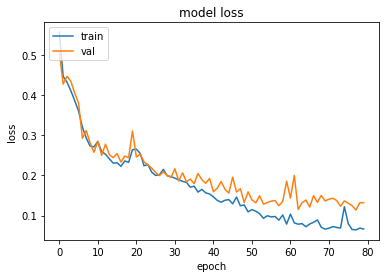

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

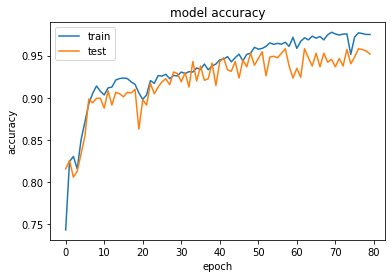

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
test=[]
for i in range(len(ytest)):
  test.append(ytest[i][0])
test=np.array(test)

In [25]:
from sklearn.metrics import classification_report
preds=model.predict(Xtest)
y_classes = preds.argmax(axis=-1)
print(classification_report(test, y_classes)) # note true when zero

              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95       561
         1.0       0.95      0.96      0.95       561

    accuracy                           0.95      1122
   macro avg       0.95      0.95      0.95      1122
weighted avg       0.95      0.95      0.95      1122



In [26]:
model.save(path+'model_snare')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/malis project/FINAL/data/snare/model_snare/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/malis project/FINAL/data/snare/model_snare/assets


In [27]:
model = keras.models.load_model(path+'model_snare')

In [28]:
from sklearn.metrics import classification_report
preds=model.predict(Xtest)
y_classes = preds.argmax(axis=-1)
print(classification_report(test, y_classes))

              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95       561
         1.0       0.95      0.96      0.95       561

    accuracy                           0.95      1122
   macro avg       0.95      0.95      0.95      1122
weighted avg       0.95      0.95      0.95      1122

